# <center>Organizaci&oacute;n de Datos</center>
## <center>Trabajo Práctico 2: Criticas de cine</center>

#### Integrantes grupo 19: Sudanalytics 
* Adrian Leandro Re
* Alan Toulouse
* Luciano Lorenzo
* Nicolas Tonizzo

Importamos las librerias y modulos necesarios.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer, f1_score, confusion_matrix, precision_score, recall_score, accuracy_score

Cargamos nuestro set de entrenamiento

In [2]:
df = pd.read_csv("dataset/train.csv")
df.head()

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


## Feature Engineering

Primero verificamos que no haya ningun valor nulo en nuestro dataframe, ya que no tendria sentido hacer el analisis de sentimientos a partir de una review vacía.

In [3]:
df['review_es'].isnull().sum()

0

Encodeamos el target para que las review positivas esten representadas por un 1 y las negativas por 0.

In [4]:
df['sentimiento_es_positivo'] = np.where(df.sentimiento == 'positivo', 1, 0)

Pasamos todos los caracteres a minúscula para que sea más fácil preporcesarlos.

In [5]:
df['review_es'] = df['review_es'].str.lower()

Quitamos los acentos de todas las palabras y reemplazamos el caracter ñ por n.

In [6]:
caracteres_especiales = {'á':'a', 'é':'e', 'í':'i', 'ó':'o', 'ú':'u', 'ñ':'n'}
for original, nuevo in caracteres_especiales.items():
    df['review_es'] = df['review_es'].str.replace(original, nuevo, regex=True)

Removemos todo caracter que no sean letras (números, puntos, comas, comillas, etc.) y los espacios dobles que puedan llegar a aparecer con esta operación.

In [7]:
df['review_es'] = df['review_es'].str.replace('[^a-zA-Z]', ' ', regex=True)
df['review_es'] = df['review_es'].str.replace('  ', ' ', regex=True)

Como último paso para el preprocesamiento, eliminamos las stopwords

In [11]:
from nltk.corpus import stopwords
palabras = '|'.join(stopwords.words('spanish'))
df['review_es'] = df['review_es'].str.replace(fr'\b({palabras})\b', '',regex=True)

Nuestro dataset preprocesado queda de la siguiente manera:

In [10]:
df.head(15)

,ID,review_es,sentimiento,sentimiento_es_positivo
0,0,criticos mencionado despues ver solo o...,positivo,1
1,1,pequena pequena produccion tecnica filmacio...,positivo,1
2,2,pense manera maravillosa pasar tiempo f...,positivo,1
3,3,basicamente familia nino pequeno jake pien...,negativo,0
4,4,amor tiempo petter mattei pelicula visua...,positivo,1
5,5,probablemente pelicula favorita tiempos h...,positivo,1
6,6,seguro gustaria ver resurreccion serie s...,positivo,1
7,7,espectaculo idea increible fresca innovado...,negativo,0
8,8,alentados comentarios positivos pelicula a...,negativo,0
9,9,si gusta risa original desgarradora gustara...,positivo,1


## Sets de test y train
Dividimos el dataframe en datos de test y train. Usaremos estos mismos sets para el entrenamiento de todos los modelos.

In [12]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

X = df.review_es
y = df.sentimiento_es_positivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

2023-06-15 19:13:09.247025: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 19:13:09.957458: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 19:13:09.959891: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 19:13:11.861358: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Ensamblado de modelos

### Bayes Naive
Primero transformamos nuestros documentos en una matriz en la cual se almacena la cantidad de tokens ("palabras clave"). Luego convertimos esa misma matriz en una representación normalizada de término/frecuencia. 
Esto lo hacemos para reducir el impacto de los tokens que aparecen más veces.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

vectorizador = CountVectorizer()
X_train_counts = vectorizador.fit_transform(X_train)

print(X_train_counts)
escaladorTfidf = TfidfTransformer()
X_train_tfidf = escaladorTfidf.fit_transform(X_train_counts)

print(X_train_tfidf)

  (0, 4843)	1
  (0, 128411)	2
  (0, 109407)	1
  (0, 26638)	1
  (0, 107610)	1
  (0, 93445)	1
  (0, 35617)	1
  (0, 33360)	1
  (0, 99324)	1
  (0, 137803)	1
  (0, 11711)	1
  (0, 140314)	2
  (0, 131011)	1
  (0, 139053)	5
  (0, 19351)	1
  (0, 129473)	1
  (0, 99852)	1
  (0, 85636)	1
  (0, 63165)	1
  (0, 103701)	1
  (0, 146910)	1
  (0, 151166)	1
  (0, 6538)	3
  (0, 42049)	1
  (0, 139343)	1
  :	:
  (39999, 35521)	1
  (39999, 149513)	1
  (39999, 11563)	1
  (39999, 35501)	1
  (39999, 119807)	1
  (39999, 16409)	1
  (39999, 70707)	1
  (39999, 138047)	1
  (39999, 90336)	2
  (39999, 116193)	2
  (39999, 85567)	1
  (39999, 47193)	1
  (39999, 26602)	1
  (39999, 16410)	1
  (39999, 69581)	3
  (39999, 16411)	1
  (39999, 109012)	1
  (39999, 46357)	1
  (39999, 95356)	1
  (39999, 112869)	1
  (39999, 148343)	1
  (39999, 71471)	1
  (39999, 18666)	3
  (39999, 149514)	1
  (39999, 125629)	1
  (0, 151956)	0.07839375983945933
  (0, 151166)	0.11323120376010341
  (0, 150776)	0.08902974801322862
  (0, 149990)	0.0746500

Ahora que tenemos la información en el formato correcto, creamos nuestro modelo de tipo Bayes Naive. En este caso usamos uno de tipo multinomial.

In [15]:
clasificadorBayesNaive = MultinomialNB()
clasificadorBayesNaive.fit(X_train_tfidf, y_train)

MultinomialNB()

Realizamos el mismo procedimiento para transformar los datos de validación y poder realizar nuestras predicciones.

In [16]:
X_test_counts = vectorizador.transform(X_test)
X_test_tfidf = escaladorTfidf.transform(X_test_counts)
y_pred = np.where(clasificadorBayesNaive.predict(X_test_tfidf) >= 0.5, 1, 0)

Construimos nuestra matriz de confusión y analizamos métricas

Text(0.5, 1.0, 'Confusion matrix de validación')

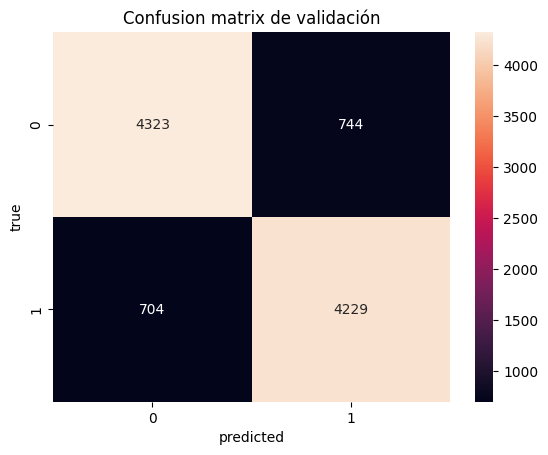

In [17]:
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, fmt='.0f')
plt.ylabel('true')
plt.xlabel('predicted')
plt.title("Confusion matrix de validación")

In [18]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

Accuracy: 0.8552
Precision: 0.8503921174341443
Recall: 0.8572876545712548
F1-score: 0.8538259640621845


Creamos el submit para la competencia de Kaggle.

In [ ]:
df_test = pd.read_csv("dataset/test.csv")
assert(len(df_test)==8599)

X = df_test['review_es']
    
X_counts = vectorizador.transform(X)
X_tfidf = escaladorTfidf.transform(X_counts)
    
prediccion = np.where(clasificadorBayesNaive.predict(X_tfidf) >= 0.5, 'positivo', 'negativo')

assert(len(prediccion)==8599)

submit = pd.DataFrame(
    {"sentimiento": prediccion},
    index=df_test["ID"],
)
assert(len(submit)==8599)

submit.to_csv("dataset/submit.csv")

### Cross validation naive bayes

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [43]:
clf_naive_bayes = MultinomialNB(fit_prior=False)

params_grid2 = {
    "alpha": np.linspace(0.3,1,40),
}

kfoldcv = StratifiedKFold(n_splits=6)

model = GridSearchCV (
    estimator=clf_naive_bayes,
    param_grid=params_grid2,
    scoring=make_scorer(f1_score),
    cv=kfoldcv,
)

model.fit(X_train_tfidf, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
             estimator=MultinomialNB(fit_prior=False),
             param_grid={'alpha': array([0.3       , 0.31794872, 0.33589744, 0.35384615, 0.37179487,
       0.38974359, 0.40769231, 0.42564103, 0.44358974, 0.46153846,
       0.47948718, 0.4974359 , 0.51538462, 0.53333333, 0.55128205,
       0.56923077, 0.58717949, 0.60512821, 0.62307692, 0.64102564,
       0.65897436, 0.67692308, 0.69487179, 0.71282051, 0.73076923,
       0.74871795, 0.76666667, 0.78461538, 0.8025641 , 0.82051282,
       0.83846154, 0.85641026, 0.87435897, 0.89230769, 0.91025641,
       0.92820513, 0.94615385, 0.96410256, 0.98205128, 1.        ])},
             scoring=make_scorer(f1_score))

In [44]:
print("Los mejores parametros encontrados son: ", model.best_params_)
print("con un f1 score: ", model.best_score_)

Los mejores parametros encontrados son:  {'alpha': 0.8384615384615384}
con un f1 score:  0.8583055484472998


In [52]:
pd.DataFrame(model.cv_results_).sort_values(by="rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
30,0.046736,0.005051,0.008673,0.000772,0.838462,{'alpha': 0.8384615384615384},0.847203,0.856112,0.872079,0.856631,0.859982,0.857826,0.858306,0.007344,1
29,0.046374,0.005445,0.008971,0.000841,0.820513,{'alpha': 0.8205128205128205},0.847249,0.856112,0.872379,0.856333,0.860238,0.857484,0.858299,0.007454,2
16,0.040436,0.001772,0.007851,0.000146,0.587179,{'alpha': 0.5871794871794871},0.848539,0.856885,0.871142,0.856760,0.859072,0.856930,0.858221,0.006671,3
31,0.040919,0.001120,0.007828,0.000258,0.85641,{'alpha': 0.8564102564102563},0.847422,0.855811,0.872079,0.856504,0.859898,0.857484,0.858200,0.007312,4
28,0.040171,0.000549,0.007724,0.000069,0.802564,{'alpha': 0.8025641025641026},0.847249,0.856112,0.871741,0.856035,0.860539,0.857356,0.858172,0.007286,5


In [46]:
X_test_counts = vectorizador.transform(X_test)
X_test_tfidf = escaladorTfidf.transform(X_test_counts)
y_pred = np.where(model.predict(X_test_tfidf) >= 0.5, 1, 0)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

Accuracy: 0.8564
Precision: 0.8521651560926485
Recall: 0.8576930873707683
F1-score: 0.8549201858961406


### Random Forest

### XGBoost

### Red neuronal con Keras y TensorFlow

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Embedding, Dense
from keras.utils import pad_sequences

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocabulario = len(tokenizer.word_index) + 1

In [ ]:
max_words = 500000
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_words)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_words)

In [ ]:
lstm_nn = Sequential()

lstm_nn.add(Embedding(vocabulario, 32, input_length=max_words,trainable=False))
lstm_nn.add(LSTM(100))
lstm_nn.add(Dense(1,activation='sigmoid'))

In [ ]:
lstm_nn.compile(optimizer='adam', loss='binary_crossentropy')
print(lstm_nn.summary())

In [ ]:
lstm_nn_history = lstm_nn.fit(X_train_padded, y_train, epochs=6)

In [ ]:
y_pred = np.where(lstm_nn.predict(X_test_padded) >= 0.5, 1, 0)

In [ ]:
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, fmt='.0f')
plt.ylabel('true')
plt.xlabel('predicted')
plt.title("Confusion matrix de validación")

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

In [ ]:
df_test = pd.read_csv("dataset/test.csv")
assert(len(df_test)==8599)

X = df_test.review_es
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=max_words)
    
prediccion = np.where(lstm_nn.predict(X_padded) >= 0.5, 'positivo', 'negativo').reshape(-1)
assert(len(prediccion)==8599)

submit = pd.DataFrame(
    {"sentimiento": prediccion},
    index=df_test["ID"],
)
assert(len(submit)==8599)

submit.to_csv("dataset/submit.csv")

### Ensamble de modelos